# Very simple word2vec example @ [nlintz's tutoral](https://github.com/nlintz/TensorFlow-Tutorials)

In [1]:
import collections
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

print ("Packages loaded.")

Packages loaded.


# Configuration

In [2]:
# Configuration
batch_size     = 20
embedding_size = 2     # This is just for visualization
num_sampled    = 15    # Number of negative examples to sample.

# Sentences, we will use

In [3]:
# Sample sentences
sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]
# 'sentences' is 'list' 
print ("'sentences' is %s and length is %d." 
       % (type(sentences), len(sentences)))

'sentences' is <class 'list'> and length is 12.


# sentences to words and count

# words: list of all words (just concatenation) 

In [4]:
words = " ".join(sentences).split() 
print ("'words' is %s and length is %d." % (type(words), len(words)))
print (words)

'words' is <class 'list'> and length is 62.
['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I', 'love', 'cats', 'and', 'dogs', 'we', 'all', 'love', 'cats', 'and', 'dogs', 'cats', 'and', 'dogs', 'are', 'great', 'sung', 'likes', 'cats', 'she', 'loves', 'dogs', 'cats', 'can', 'be', 'very', 'independent', 'cats', 'are', 'great', 'companions', 'when', 'they', 'want', 'to', 'be', 'cats', 'are', 'playful', 'cats', 'are', 'natural', 'hunters', "It's", 'raining', 'cats', 'and', 'dogs', 'dogs', 'and', 'cats', 'love', 'sung']


# count: list of pairs, each pair consists of 'cats', 10

In [5]:
count = collections.Counter(words).most_common() 
print ("'count' is %s and length is %d." % (type(count), len(count)))
print (("Word count of top five is %s") % (count[:5]))
print (count)

'count' is <class 'list'> and length is 35.
Word count of top five is [('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3)]
[('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3), ('the', 2), ('great', 2), ('sung', 2), ('be', 2), ('quick', 1), ('brown', 1), ('fox', 1), ('jumped', 1), ('over', 1), ('lazy', 1), ('dog', 1), ('I', 1), ('we', 1), ('all', 1), ('likes', 1), ('she', 1), ('loves', 1), ('can', 1), ('very', 1), ('independent', 1), ('companions', 1), ('when', 1), ('they', 1), ('want', 1), ('to', 1), ('playful', 1), ('natural', 1), ('hunters', 1), ("It's", 1), ('raining', 1)]


# See what's in the 'words' and 'count'

In [6]:
print (words[0:5])
print (count[0:3])

['the', 'quick', 'brown', 'fox', 'jumped']
[('cats', 10), ('dogs', 6), ('and', 5)]


# Build dictionaries

In [6]:
rdic = [i[0] for i in count] #reverse dic, idx -> word
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id
voc_size = len(dic) # Number of vocabulary 
print ("'rdic' is %s and length is %d." % (type(rdic), len(rdic)))
print ("'dic' is %s and length is %d." % (type(dic), len(dic)))

'rdic' is <class 'list'> and length is 35.
'dic' is <class 'dict'> and length is 35.


In [7]:
print (rdic)

['cats', 'dogs', 'and', 'are', 'love', 'the', 'great', 'sung', 'be', 'quick', 'brown', 'fox', 'jumped', 'over', 'lazy', 'dog', 'I', 'we', 'all', 'likes', 'she', 'loves', 'can', 'very', 'independent', 'companions', 'when', 'they', 'want', 'to', 'playful', 'natural', 'hunters', "It's", 'raining']


In [8]:
print (dic)

{'cats': 0, 'dogs': 1, 'and': 2, 'are': 3, 'love': 4, 'the': 5, 'great': 6, 'sung': 7, 'be': 8, 'quick': 9, 'brown': 10, 'fox': 11, 'jumped': 12, 'over': 13, 'lazy': 14, 'dog': 15, 'I': 16, 'we': 17, 'all': 18, 'likes': 19, 'she': 20, 'loves': 21, 'can': 22, 'very': 23, 'independent': 24, 'companions': 25, 'when': 26, 'they': 27, 'want': 28, 'to': 29, 'playful': 30, 'natural': 31, 'hunters': 32, "It's": 33, 'raining': 34}


# See what's in the 'rdic' and 'rdic'

In [9]:
print (rdic[0])
print (dic['cats'])

cats
0


# Make indexed word data (ordered)

In [10]:
data = [dic[word] for word in words]
print ("'data' is %s and length is %d." % (type(data), len(data)))
print('Sample data: numbers: %s / words: %s'% (data[:10], [rdic[t] for t in data[:10]]))

'data' is <class 'list'> and length is 62.
Sample data: numbers: [5, 9, 10, 11, 12, 13, 5, 14, 15, 16] / words: ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I']


In [11]:
# See what's in the data
print (data)

[5, 9, 10, 11, 12, 13, 5, 14, 15, 16, 4, 0, 2, 1, 17, 18, 4, 0, 2, 1, 0, 2, 1, 3, 6, 7, 19, 0, 20, 21, 1, 0, 22, 8, 23, 24, 0, 3, 6, 25, 26, 27, 28, 29, 8, 0, 3, 30, 0, 3, 31, 32, 33, 34, 0, 2, 1, 1, 2, 0, 4, 7]


# Let's make a training data for window size 1 for simplicity

In [12]:
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox),
cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
print('Context pairs: %s' % (cbow_pairs[:10]))

Context pairs: [[[5, 10], 9], [[9, 11], 10], [[10, 12], 11], [[11, 13], 12], [[12, 5], 13], [[13, 14], 5], [[5, 15], 14], [[14, 16], 15], [[15, 4], 16], [[16, 0], 4]]


# See type and length of 'cbow_pairs'

In [13]:
print ("'cbow_pairs' is %s and length is %d." 
       % (type(cbow_pairs), len(cbow_pairs)))

'cbow_pairs' is <class 'list'> and length is 60.


# Let's make skip-gram pairs

In [14]:
# (quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
    
print ("'skip_gram_pairs' is %s and length is %d."
       % (type(skip_gram_pairs), len(skip_gram_pairs)))
print('skip-gram pairs', skip_gram_pairs[:5])

'skip_gram_pairs' is <class 'list'> and length is 120.
skip-gram pairs [[9, 5], [9, 10], [10, 9], [10, 11], [11, 10]]


In [15]:
def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

# generate_batch test
print ('Batches (x, y)', generate_batch(3))

Batches (x, y) ([2, 18, 0], [[1], [4], [20]])


# Construct network

In [17]:
# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# missing GPU implementation?
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                 num_sampled, voc_size))

# Use the adam optimizer
train_op = tf.train.AdamOptimizer(0.01).minimize(loss)
print ("Network ready")

Network ready


# Run!

In [18]:
# Launch the graph in a session
with tf.Session() as sess:
    # Initializing all variables
    tf.initialize_all_variables().run()

    for step in range(3000):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        if step % 500 == 0:
            print("Loss at %d: %.5f" % (step, loss_val)) 
            # Report the loss

    # Final embeddings are ready for you to use. 
    # Need to normalize for practical use
    trained_embeddings = embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


InternalError: Blas GEMM launch failed : a.shape=(20, 2), b.shape=(15, 2), m=20, n=15, k=2
	 [[Node: nce_loss_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_lookup_1/_19, nce_loss_1/Slice_1)]]
	 [[Node: Adam/update_Variable_5/group_deps/_50 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_504_Adam/update_Variable_5/group_deps", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'nce_loss_1/MatMul', defined at:
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tornado\platform\asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tornado\platform\asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-85a516940495>", line 20, in <module>
    num_sampled, voc_size))
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tensorflow\python\ops\nn_impl.py", line 1160, in nce_loss
    name=name)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tensorflow\python\ops\nn_impl.py", line 990, in _compute_sampled_logits
    sampled_logits = math_ops.matmul(inputs, sampled_w, transpose_b=True)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1891, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2436, in _mat_mul
    name=name)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\RYU\Anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(20, 2), b.shape=(15, 2), m=20, n=15, k=2
	 [[Node: nce_loss_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_lookup_1/_19, nce_loss_1/Slice_1)]]
	 [[Node: Adam/update_Variable_5/group_deps/_50 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_504_Adam/update_Variable_5/group_deps", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [19]:
trained_embeddings.shape

(35, 2)

# Plot results

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


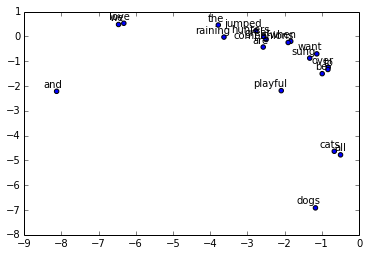

In [20]:
# Show word2vec if dim is 2
if trained_embeddings.shape[1] == 2:
    labels = rdic[:20] # Show top 20 words
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.show()